# Fuzzy Logic
## Assignment 2 - Introduction to Artificial Intelligence

#### Student ID: 1301184521
#### Name      : Lalu M. Riza Rizky
#### Class     : IF-42-INT

You are given Mahasiswa.xls containing data of 100 students with two attributes: Penghasilan (Monthly income, real number) and Pengeluaran (Monthly expenses, real number) of a family and the unit is millions IDR.
Build a fuzzy logic based system to select 20 students who are eligible for registration fee assistance of 50%. The system reads the input file Mahasiswa.xls and outputs a Bantuan.xls file which contains one column vector containing 20 rows of integer-valued numbers (whole numbers) that represent the row / record numbers (1-100) in the Mahasiswa.xls file.

Things you must observe:
* Number and Linguistic Names for each input
* Shape and Range of Input Membership Functions
* Inference Rules
* Defuzzification Method
* Shape dan Range of Output Membership Functions (as appropriate with your chosen defuzzification method)

Processes you need to build (can be functions/procedures):
* Read file
* Fuzzification
* Inference
* Defuzzification

Output from your sistem a Bantuan.xls file which contains one column vector containing 20 rows of integer-valued numbers (whole numbers) that represent the row / record numbers (1-100) in the Mahasiswa.xls file.

## Program Specification
* Language: R, with Jupyter Notebook
* Library: xlsx library for R
* Membership Function Type: Trapezoidal
* Total Fuzzy Rule: 9
* Defuzzification Method: Center of Gravity (Mamdani)

## Step Rundown

#### 1. Import library to handle .xlsx file
This is mandatory since R does not have a library directly to read an .xlsx file.

In [1]:
library(xlsx)

#### 2. Read given dataset
Import the dataset file, 'mahasiswa.xlsx' given with the assignment. In this case, the file has been converted to a .csv file.

In [2]:
dataset <- read.csv('mahasiswa.csv')
head(dataset, 10)

,Id,Penghasilan,Pengeluaran
,<int>,<dbl>,<dbl>
1,1,18.76,9.68
2,2,8.35,4.52
3,3,17.03,10.11
4,4,8.23,9.25
5,5,16.89,6.99
6,6,15.19,7.20
7,7,9.03,9.35
8,8,17.99,7.10
9,9,17.09,10.54


#### 3. Determine the membership function
In order to help determining the membership function both for income and expense, summary of the dataset are generated through the function directly given by R.

In [3]:
summary(dataset[c('Penghasilan', 'Pengeluaran')])

  Penghasilan      Pengeluaran    
 Min.   : 4.620   Min.   : 3.440  
 1st Qu.: 9.617   1st Qu.: 7.393  
 Median :14.805   Median : 8.600  
 Mean   :13.779   Mean   : 8.381  
 3rd Qu.:17.045   3rd Qu.: 9.807  
 Max.   :19.690   Max.   :11.290  

The membership function is using the trapedoizal based version. To make sure that the definition of membership function is easier, create a base function for the membership function. There are three versions defined in this program:
1. Trapezoidal
2. Trapezoidal Ascend
3. Trapezoidal Descend

In [4]:
membership.trapezoid <- function(x_min, x_max, x_minavg, x_maxavg) {
    return(function(x) {
        val <- 1
        if (x <= x_min || x >= x_max) {
            val <- 0
        } else if (x > x_min && x < x_minavg) {
            val <- (x - x_min) / (x_minavg - x_min)
        } else if (x > x_maxavg && x < x_max) {
            val <- -(x - x_max) / (x_max - x_maxavg)
        }
        return(val)
    })
}

In [5]:
membership.trapezoid_ascend <- function(x_min, x_max) {
    return(function(x) {
        val <- 1
        if (x <= x_min) {
            val <- 0
        } else if (x > x_min && x <= x_max) {
            val <- (x - x_min) / (x_max - x_min)
        }
        return(val)
    })
}

In [6]:
membership.trapezoid_descend <- function(x_min, x_max) {
    return(function(x) {
        val <- 1
        if (x > x_max) {
            val <- 0
        } else if (x > x_min && x <= x_max) {
            val <- (x_max - x) / (x_max - x_min)
        }
        return(val)
    })
}

Next, determine the membership range for income, expense, and result. Based on the data observation, the defined ranges for the membership function of each input are:

1. Income:
- Low Membership:
    + Minimum: 5
    + Maximum: 7
- Average Membership:
    + Lower Minimum: 6
    + Lower Maximum: 14
    + Upper Minimum: 8
    + Upper Maximum: 12
- High Membership:
    + Minimum: 11
    + Maximum: 16

In [7]:
income_membership.low <- membership.trapezoid_descend(5, 7)
income_membership.average <- membership.trapezoid(6, 14, 8, 12)
income_membership.high <- membership.trapezoid_ascend(11, 16)
income_membership <- function(type, income) {
    value <- income_membership.low(income)
    if (type == "average") {
        value <- income_membership.average(income)
    } else if (type == "high") {
        value <- income_membership.high(income)
    }
    return(value)
}

2. Expense:
- Low Membership:
    + Minimum: 4
    + Maximum: 6
- Average Membership:
    + Lower Minimum: 5
    + Lower Maximum: 9
    + Upper Minimum: 6
    + Upper Maximum: 8
- High Membership:
    + Minimum: 8
    + Maximum: 10

In [8]:
expense_membership.low <- membership.trapezoid_descend(4, 6)
expense_membership.average <- membership.trapezoid(5, 9, 6, 8)
expense_membership.high <- membership.trapezoid_ascend(8, 10)
expense_membership <- function(type, expense) {
    value <- expense_membership.low(expense)
    if (type == "average") {
        value <- expense_membership.average(expense)
    } else if (type == "high") {
        value <- expense_membership.high(expense)
    }
    return(value)
}

3. Result:
- Reject Membership:
    + Minimum: 40
    + Maximum: 60
+ Consider Membership:
    + Lower Minimum: 55
    + Lower Maximum: 80
    + Upper Average: 60
    + Upper Average: 70
+ Accept Membership:
    + Minimum: 75
    + Maximum: 85

In [9]:
result_membership.reject <- membership.trapezoid_descend(40, 60)
result_membership.consider <- membership.trapezoid(55, 80, 60, 70)
result_membership.accept <- membership.trapezoid_ascend(75, 85)

After the membership function has been defined, the function can be visualized as a plot as shown below:

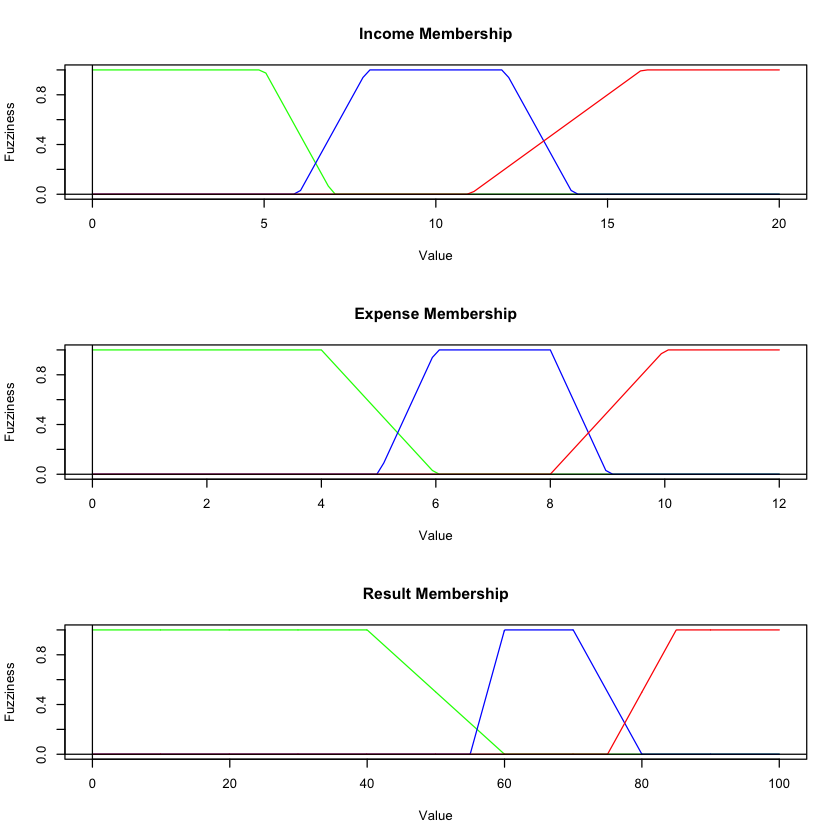

In [10]:
# Income membership range value
a <- seq(0, 20, length.out = 100)
c <- lapply(a, income_membership.low)
d <- lapply(a, income_membership.average)
e <- lapply(a, income_membership.high)

# Expense membership range value
b <- seq(0, 12, length.out = 100)
f <- lapply(b, expense_membership.low)
g <- lapply(b, expense_membership.average)
h <- lapply(b, expense_membership.high)

# Result membership range value
sequence <- seq(0, 100, length.out = 1000)
result_sequence.reject <- lapply(sequence, result_membership.reject)
result_sequence.consider <- lapply(sequence, result_membership.consider)
result_sequence.accept <- lapply(sequence, result_membership.accept)

# Create 3x1 plot grouping
par(mfrow = c(3, 1))

# Plot income membership
plot(a, c, type = "l", ylab = "Fuzziness", xlab = "Value", col = "green")
title("Income Membership")
lines(a, d, col = "blue")
lines(a, e, col = "red")
abline(h = 0)
abline(v = 0)

# Plot expense membership
plot(b, f, type = "l", ylab = "Fuzziness", xlab = "Value", col = "green")
title("Expense Membership")
lines(b, g, col = "blue")
lines(b, h, col = "red")
abline(h = 0)
abline(v = 0)

# Plot result membership
plot(sequence, result_sequence.reject, type = "l", ylab = "Fuzziness", xlab = "Value", col = "green")
title("Result Membership")
lines(sequence, result_sequence.consider, col = "blue")
lines(sequence, result_sequence.accept, col = "red")
abline(h = 0)
abline(v = 0)

#### 4. Determine Fuzzy Rules
Based on the input sample given, the ones appropriate to receive aid is the ones that mainly have a low income. The rules can be applied in the table as shown below:

In [11]:
rules <- read.csv('fuzzy-rules.csv')
rules

id,income,expense,result
<int>,<chr>,<chr>,<chr>
1,low,low,consider
2,low,average,accept
3,low,high,accept
4,average,low,reject
5,average,average,consider
6,average,high,accept
7,high,low,reject
8,high,average,reject
9,high,high,consider


#### 5. Inference
Firstly, the fuzzy values are calculated both for income, expense, and the result. Result fuzzy values are based on the minimum value between income and expense fuzzy value. The function implementation can be as shown in code below:

In [12]:
generate_fuzzy_table <- function(data, rules) {
    data_id <- c()
    data_id[1:nrow(rules)] <- data$Id
    income <- c()
    income[1:nrow(rules)] <- data$Penghasilan
    expense <- c()
    expense[1:nrow(rules)] <- data$Pengeluaran
    income_fuzzy <- c()
    expense_fuzzy <- c()
    result_fuzzy <- c()
    for (i in 1:nrow(rules)) {
        income_fuzzy <- c(income_fuzzy, income_membership(rules[i, "income"], data$Penghasilan))
        expense_fuzzy <- c(expense_fuzzy, expense_membership(rules[i, "expense"], data$Pengeluaran))
        current_length <- length(income_fuzzy)
        result_fuzzy <- c(result_fuzzy, min(income_fuzzy[current_length], expense_fuzzy[current_length]))
    }
    return(data.frame(
        data_id = data_id,
        id = rules$id,
        income = income,
        income_rule = rules$income, 
        income_fuzzy = income_fuzzy,
        expense = expense,
        expense_rule = rules$expense,
        expense_fuzzy = expense_fuzzy,
        result_rule = rules$result,
        result_fuzzy = result_fuzzy
    ))
}

Next, a new dataframe is created to store the values with its fuzzy values. The sample output can be shown below where it only shows the first 5 values of income, expense, and results fuzzy value. The total count for the values is rule count multiplied by data count. So the total data is $9\times100=900$. For the sample below, the total data is $9\times5=45$.

In [13]:
new_dataset <- data.frame()
for (i in 1:nrow(dataset)) {
    fuzzy_table <- generate_fuzzy_table(dataset[i, ], rules)
    new_dataset <- rbind(new_dataset, fuzzy_table)
}
new_dataset[1:45,]

,data_id,id,income,income_rule,income_fuzzy,expense,expense_rule,expense_fuzzy,result_rule,result_fuzzy
,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,1,1,18.76,low,0,9.68,low,0.000,consider,0.000
2,1,2,18.76,low,0,9.68,average,0.000,accept,0.000
3,1,3,18.76,low,0,9.68,high,0.840,accept,0.000
4,1,4,18.76,average,0,9.68,low,0.000,reject,0.000
5,1,5,18.76,average,0,9.68,average,0.000,consider,0.000
6,1,6,18.76,average,0,9.68,high,0.840,accept,0.000
7,1,7,18.76,high,1,9.68,low,0.000,reject,0.000
8,1,8,18.76,high,1,9.68,average,0.000,reject,0.000
9,1,9,18.76,high,1,9.68,high,0.840,consider,0.840


In order to infer the value for each row of data, the data will be used as argument which has a length based on the row count of the rules itself. The inference step selects the maximum value for each result rules defined.

In [14]:
inference <- function(data) {
    selected_column <- c('data_id', 'result_rule', 'result_fuzzy')
    reject <- data$result_rule == 'reject'
    consider <- data$result_rule == 'consider'
    accept <- data$result_rule == 'accept'
    data <- data[selected_column]
    reject_data <- data[reject, selected_column]
    consider_data <- data[consider, selected_column]
    accept_data <- data[accept, selected_column]
    id = data[1, 'data_id']
    return(data.frame(
        id = id,
        reject = max(reject_data$result_fuzzy),
        consider = max(consider_data$result_fuzzy),
        accept = max(accept_data$result_fuzzy)
    ))
}

The inference process for all data will results in the same length as the data count in dataset. Based on the sample, since the sample size is 45, it will be reduced down to 5 data only since the result has been inferred. The sample data can be shown below:

In [15]:
fuzzy_output_df <- data.frame()
for (i in seq(1, nrow(new_dataset), nrow(rules))) {
    inferred_data <- inference(new_dataset[seq(i, i+nrow(rules)-1),])
    fuzzy_output_df <- rbind(fuzzy_output_df, inferred_data)
}
fuzzy_output_df[1:5,]

,id,reject,consider,accept
,<int>,<dbl>,<dbl>,<dbl>
1,1,0.00,0.84,0.000
2,2,0.74,0.00,0.000
3,3,0.00,1.00,0.000
4,4,0.00,0.00,0.625
5,5,1.00,0.00,0.000


#### 5. Defuzzificaton (Center of Gravity, Mamdani)
Before doing fuzzification step, there are couple of functions need to be considered in this program. Since the defuzzification process is using center of gravity method. The first things that should be done is to generate a random sequence for the result membership which has been generated in the previous step and grouped into a dataframe. Next, replace values that is in range of, $0\leq x_i \leq \mu B(z_i)$ with $x_i$ being the inferred result from the previous step. The functions explained can be implemented as below:

In [16]:
# Group all result membership sequences and membership result into a dataframe
result_list <- list(sequence, 
                    result_sequence.reject, 
                    result_sequence.consider, 
                    result_sequence.accept
                   )
result_df <- data.frame(matrix(unlist(result_list), nrow = length(sequence)))
colnames(result_df) <- c('x', 'reject', 'consider', 'accept')

In [17]:
# Replace values that is in range of, 0 <= x <= maxfuzzy of each membership from inference
replace_value <- function(table, row) {
    for (i in 1:nrow(table)) {
        if (row['reject'] <= table[i, 'reject']) table[i, 'reject'] <- row['reject']
        if (row['consider'] <= table[i, 'consider']) table[i, 'consider'] <- row['consider']
        if (row['accept'] <= table[i, 'accept']) table[i, 'accept'] <- row['accept']
    }
    return(table)
} 

As stated, the fuzzification method implemented is using center of gravity (Mamdani). The formula for this method is: $\frac{\sum_{i=1}^n \mu B(z_i) z_i}{\sum_{i=1}^n \mu B(z_i)}$ where $\mu B(z_i) \text{: Membership of the } i^{th} \text{ value}$ and $z_i \text{: } i^{th} \text{ value of the generated sequence}$. The implementation firstly replaces values using the previously implemented function which then used to find max fuzzy values between the defined sequence. Then, the max value multiplied by the values of generated sequence. Finally, the multiplied value and the max fuzzy value are both summed and divided to get the crisp result, which is the center of gravity. The implementation can be shown as below:

In [18]:
center_of_gravity <- function(table, row) {
    new_table <- replace_value(table, row)
    new_table[, 'max'] <- apply(new_table[c('reject', 'consider', 'accept')], 1, max)
    new_table[, 'max*x'] <- apply(new_table, 1, function(x) {
        return(x['max'] * x['x'])
    })
    return(sum(new_table['max*x'])/sum(new_table['max']))
}

The data from inference is used to calculate the crisp value of each row that has the inferred values. Here is the first 5 samples of the crisp value generated.

In [19]:
result_crisp_df <- data.frame()
for (i in 1:nrow(fuzzy_output_df)) {
    new_row <- list(
        id = fuzzy_output_df[i, 'id'],
        value = center_of_gravity(result_df, fuzzy_output_df[i, ])
    )
    result_crisp_df <- rbind(result_crisp_df, new_row)
}
result_crisp_df[1:5,]

,id,value
,<int>,<dbl>
1,1,66.56788
2,2,26.44833
3,3,66.42854
4,4,89.01327
5,5,25.30799


#### 6. Fetch first 20 data with maximum crisp value
The defuzzified data is sorted based on the crisp value descendingly, selects the id column, and sorted again ascendingly based on id.

In [20]:
final <- result_crisp_df[order(result_crisp_df['value'], decreasing = TRUE),]
final <- final[1:20,]
final <- final[order(final['id']),]
final <- final['id']
final

,id
,<int>
4,4
7,7
11,11
13,13
33,33
38,38
41,41
46,46
47,47


Finally, the data is exported as 'bantuan.xlsx' which contains the top 20 students that accepted for aid.

In [21]:
write.xlsx2(final, 'bantuan.xlsx', row.names=FALSE)